In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np 
import os
from pathlib import Path 
import pandas as pd 
import seaborn as sns 

plt.style.use('ggplot')

DATA_DIR = Path("../../data")
JOKES_DIR = DATA_DIR / "jokes"
BERT_EMBEDDINGS = DATA_DIR / "bert_embeddings"
FASTTEXT_EMBEDDINGS = DATA_DIR / "fasttext_embeddings"

In [3]:
NAN = 99

In [4]:
ratings_path = DATA_DIR / 'jester-data-1.xls'
xl = pd.ExcelFile(ratings_path)
print(xl.sheet_names)
ratings = xl.parse(xl.sheet_names[0], header=None)
ratings = ratings.loc[:, 1:]

['jester-data-1-new']


## Analiza Danych

Oceny żartów są z przedziału [-10, 10], jednak w danych występuje też wartość 99, która oznacza brak oceny. Pierwsza kolumna oznacza ilość wystawionych przez użytkownika ocen, jednak ta informacja zdaje się zbędna w kontekście problemu, bo nie chcemy uczyć modelu konkretnie dla tego zbioru, tak więc ta kolumna zostanie usunięta.

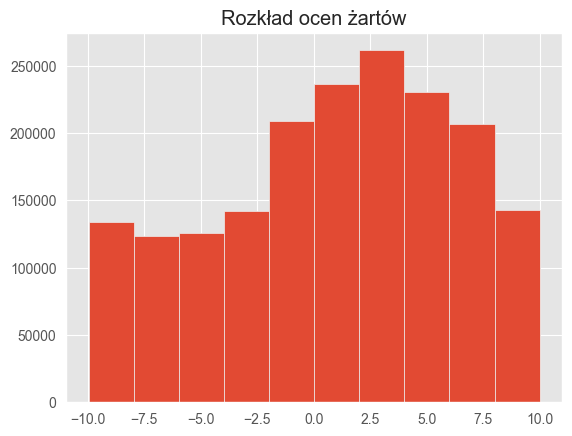

In [5]:
plt.title('Rozkład ocen żartów')
_ = plt.hist(ratings[ratings < NAN].values.flatten())

Około 28% ocen to wartości puste

In [6]:
np.round(np.sum(np.sum(ratings >= NAN)) / ratings.size, 2)

C:\Users\julia\VSCode\AI-and-Data-Engineering\.venv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


0.28

C:\Users\julia\VSCode\AI-and-Data-Engineering\.venv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


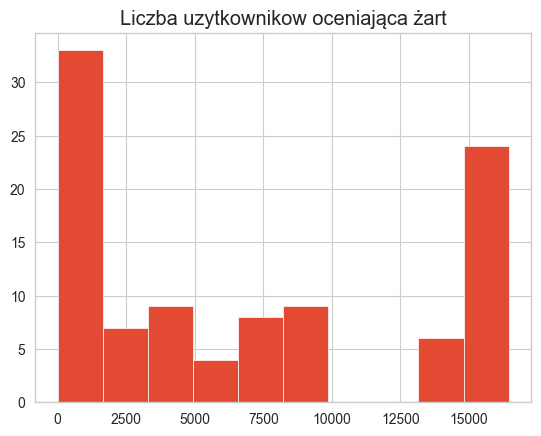

In [18]:
users_per_jokes_ratings = np.sum(ratings >= NAN)
plt.title('Liczba uzytkownikow oceniająca żart')
_ = plt.hist(users_per_jokes_ratings)

In [8]:
percentage_users_rated = users_per_jokes_ratings / ratings.shape[0]

In [9]:
user_group_ratings = pd.cut(percentage_users_rated, bins=5, labels=['< 20%', '20 - 40%', '40 - 60%', '60 - 80%', '80 - 100%'])

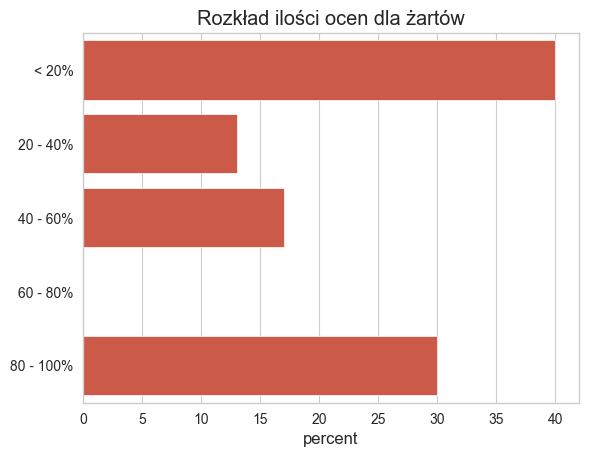

In [19]:
plt.title('Rozkład ilości ocen dla żartów')
_ = sns.countplot(user_group_ratings, stat='percent')

Ważne jest to, by podczas obliczania średniej oceny nie brać pod uwagę ocen o wartości 99

In [11]:
ratings_description = ratings[ratings < NAN].describe().transpose()
ratings_description['% user'] = percentage_users_rated
ratings_description['% user cat'] = user_group_ratings

In [12]:
ratings_description = ratings_description.reset_index().rename({'index': 'joke_id'}, axis=1)

In [13]:
ratings_description.head()

,joke_id,count,mean,std,min,25%,50%,75%,max,% user,% user cat
0,1,16452.0,0.904573,5.171798,-9.95,-2.67,1.60,4.90,9.37,0.341472,40 - 60%
1,2,18184.0,0.208460,5.597327,-9.95,-4.42,0.83,4.82,9.37,0.272145,40 - 60%
2,3,16642.0,0.316574,5.399806,-9.95,-4.03,0.78,4.66,9.37,0.333867,40 - 60%
3,4,15608.0,-1.449114,5.234654,-9.95,-5.87,-1.46,2.52,9.37,0.375255,40 - 60%
4,5,24977.0,0.403556,5.255700,-9.95,-3.69,1.12,4.47,9.37,0.000240,< 20%


Widać, że średnie oceny wahają się w przedziale [-4, 4], natomiast odchylenia standardowe są dosyć duże (w kontekście zakresu ocen) - w przedziale [4, 6]. Widać również, że minimalna ocena jest praktycznie taka sama dla wszystkich żartów, ale maksymalna ma trochę bardziej różnorodny rozkład, chociaż mocno stronniczy.

(array([62.,  3.,  1.,  7.,  2.,  2.,  7.,  7.,  5.,  4.]),
 array([ 9.37 ,  9.433,  9.496,  9.559,  9.622,  9.685,  9.748,  9.811,
         9.874,  9.937, 10.   ]),
 <BarContainer object of 10 artists>)

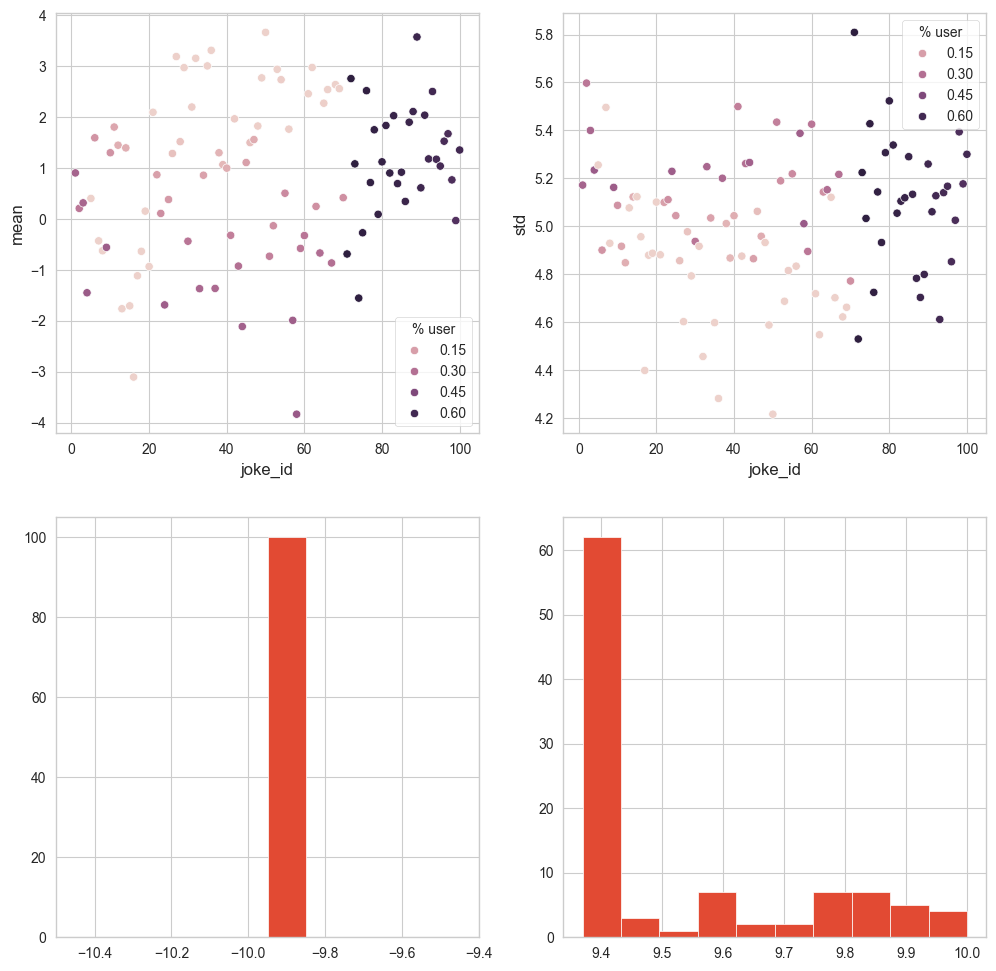

In [20]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
sns.scatterplot(ratings_description, x='joke_id', y='mean', hue='% user')
plt.subplot(2, 2, 2)
sns.scatterplot(ratings_description, x='joke_id', y='std', hue='% user')
plt.subplot(2, 2, 3)
plt.hist(ratings_description['min'])
plt.subplot(2, 2, 4)
plt.hist(ratings_description['max'])

In [26]:
ratings_description['|mean - median|'] = abs(ratings_description['mean'] - ratings_description['50%'])

W przypadku mediany możemy zauważyć, że podobnie rozkłada się ona w przedziale [-4, 4], natomiast absolutna różnica między średnią a medianą wynosi zwykle nie więcej niż 1. Jest to o tyle pomocne, że 

<Axes: xlabel='joke_id', ylabel='|mean - median|'>

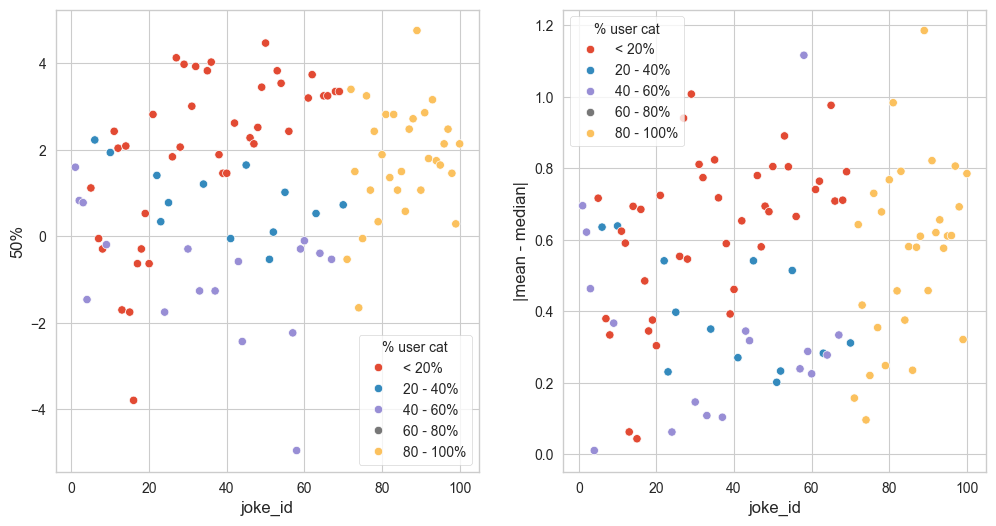

In [29]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(ratings_description, x='joke_id', y='50%', hue='% user cat')
plt.subplot(1, 2, 2)
sns.scatterplot(ratings_description, x='joke_id', y='|mean - median|', hue='% user cat')

(array([32.,  7.,  1.,  0.,  2.,  2.,  0.,  0.,  0., 14.]),
 array([-9.66 , -7.951, -6.242, -4.533, -2.824, -1.115,  0.594,  2.303,
         4.012,  5.721,  7.43 ]),
 <BarContainer object of 10 artists>)

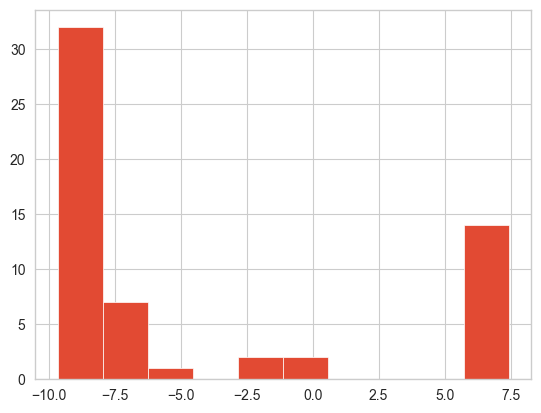

In [33]:
plt.hist(ratings.loc[58, ratings[58] < NAN])

## Trenowanie sieci

In [34]:
X = np.zeros((100, 768))

In [ ]:
for f in os.listdir(BERT_EMBEDDINGS):
    joke_num = int(f.split(".")[0][4:])
    x = np.load(BERT_EMBEDDINGS / f)
    X[joke_num - 1] = x

In [ ]:
X

In [ ]:
ratings_path = DATA_DIR / 'jester-data-1.xls'
xl = pd.ExcelFile(ratings_path)

In [ ]:
xl.sheet_names

In [ ]:
ratings = xl.parse(xl.sheet_names[0], header=None)

In [ ]:
def create_dataset(embeddings, ratings):
    # X are embeddings 
    # y are ratings 
    X = embeddings.astype(np.float32)
    X = np.repeat(embeddings, len(ratings), axis=0)  # n ratings x 101, embedding size 
    y = ratings.loc[:, 1:].values.transpose().reshape(-1)
    return X, y

In [ ]:
np.repeat(np.array([1, 2, 3]), 3)

In [ ]:
ratings

In [ ]:
plt.hist(np.sum(ratings.loc[:, 1:].values > 10, axis=0) / len(ratings))

In [ ]:
np.sum(ratings.loc[:, 1:].values > 10) / 2498300

In [ ]:
transformed = ratings.loc[:, 1:].values.transpose().reshape(-1)

In [ ]:
transformed.shape

In [ ]:
transformed[:10]

In [ ]:
np.repeat(X, 2, axis=0)

In [ ]:
X, y = create_dataset(X, ratings)